# 深度学习在投资组合优化中的应用

欢迎使用xiaojiucai库！这个教程将帮助您开始使用我们的深度学习投资组合优化工具。

## 本教程包括：

1. 加载和预处理金融数据
2. 构建深度学习模型
3. 训练和优化模型
4. 评估和可视化结果

让我们开始吧！

In [1]:
# 添加项目根目录到Python路径
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

# 导入必要的库
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置随机种子以保证可重复性
torch.manual_seed(42)
np.random.seed(42)

# 设置绘图样式
plt.style.use('default')  # 使用默认样式
sns.set_style("whitegrid")  # 使用seaborn的网格样式

In [2]:
# 设置matplotlib支持中文显示
import matplotlib.font_manager as fm

# 尝试多个中文字体文件
font_paths = [
    '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc',  # 文泉驿正黑
    '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'  # 文泉驿微米黑
]

# 添加所有可用的中文字体
for font_path in font_paths:
    if os.path.exists(font_path):
        fm.fontManager.addfont(font_path)

# 设置字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 验证当前字体设置
print("\n当前字体设置：")
print(f"font.family: {plt.rcParams['font.family']}")
print(f"font.sans-serif: {plt.rcParams['font.sans-serif']}")

# 列出所有已注册的字体
print("\n已注册的字体：")
fonts = [f.name for f in fm.fontManager.ttflist]
chinese_fonts = [f for f in fonts if any(c in f for c in ['WenQuanYi', '文泉'])]
for font in chinese_fonts:
    print(f"- {font}")


当前字体设置：
font.family: ['sans-serif']
font.sans-serif: ['WenQuanYi Zen Hei', 'WenQuanYi Micro Hei']

已注册的字体：
- WenQuanYi Zen Hei
- WenQuanYi Micro Hei


## 加载数据

我们将使用Magnificent 7（AAPL、AMZN、GOOGL、META、MSFT、NVDA、TSLA）的每日收盘价数据。数据已经通过data/mag7_data_raw.parquet保存。

In [3]:
# 加载原始数据
data_raw = pd.read_parquet('../data/mag7_data_raw.parquet')
print("数据形状:", data_raw.shape)
print("\n前5行数据:")
display(data_raw.head())

数据形状: (5027, 35)

前5行数据:


Price          Close                                                   \
Ticker          AAPL    AMZN     GOOGL META       MSFT      NVDA TSLA   
Date                                                                    
2005-09-26  1.616283  2.1670  7.810992  NaN  17.601694  0.251990  NaN   
2005-09-27  1.604275  2.1580  7.802541  NaN  17.650463  0.252831  NaN   
2005-09-28  1.533428  2.1685  7.605204  NaN  17.880327  0.254360  NaN   
2005-09-29  1.571253  2.2395  7.695174  NaN  18.068390  0.259632  NaN   
2005-09-30  1.609379  2.2650  7.865171  NaN  17.922119  0.261924  NaN   

Price           High                    ...       Open                 \
Ticker          AAPL    AMZN     GOOGL  ...       MSFT      NVDA TSLA   
Date                                    ...                             
2005-09-26  1.637897  2.1710  7.976766  ...  17.692244  0.251838  NaN   
2005-09-27  1.628291  2.1865  7.913637  ...  17.671360  0.253060  NaN   
2005-09-28  1.594369  2.1870  7.831371  ...  17.685294  0.253595  NaN   
2005-09-29  1.578758  2.2400  7.722513  ...  17.838530  0.254436  NaN   
2005-09-30  1.610579  2.2920  7.891019  ...  18.047498  0.259784  NaN   

Price           Volume                                                       
Ticker            AAPL       AMZN      GOOGL META      MSFT       NVDA TSLA  
Date                                                                         
2005-09-26   546562800  112328000  395380224  NaN  56203700  406776000  NaN  
2005-09-27   341703600   83470000  274649076  NaN  48797900  404160000  NaN  
2005-09-28  1125544000   64794000  319576104  NaN  71019400  353556000  NaN  
2005-09-29   636846000  127856000  224327448  NaN  66807100  513372000  NaN  
2005-09-30   531633200  121120000  365685948  NaN  57644500  458832000  NaN  

[5 rows x 35 columns]

In [4]:
# 检查数据结构
print("\n数据列名:")
print(data_raw.columns)
print("\n数据列名类型:")
print(type(data_raw.columns))
if hasattr(data_raw.columns, 'levels'):
    print("\n多重索引的层级:")
    for i, level in enumerate(data_raw.columns.levels):
        print(f"Level {i}: {level.values}")


数据列名:
MultiIndex([( 'Close',  'AAPL'),
            ( 'Close',  'AMZN'),
            ( 'Close', 'GOOGL'),
            ( 'Close',  'META'),
            ( 'Close',  'MSFT'),
            ( 'Close',  'NVDA'),
            ( 'Close',  'TSLA'),
            (  'High',  'AAPL'),
            (  'High',  'AMZN'),
            (  'High', 'GOOGL'),
            (  'High',  'META'),
            (  'High',  'MSFT'),
            (  'High',  'NVDA'),
            (  'High',  'TSLA'),
            (   'Low',  'AAPL'),
            (   'Low',  'AMZN'),
            (   'Low', 'GOOGL'),
            (   'Low',  'META'),
            (   'Low',  'MSFT'),
            (   'Low',  'NVDA'),
            (   'Low',  'TSLA'),
            (  'Open',  'AAPL'),
            (  'Open',  'AMZN'),
            (  'Open', 'GOOGL'),
            (  'Open',  'META'),
            (  'Open',  'MSFT'),
            (  'Open',  'NVDA'),
            (  'Open',  'TSLA'),
            ('Volume',  'AAPL'),
            ('Volume',  'AMZN'),
   

现在我们需要计算每日回报率。我们将使用对数回报率，因为它具有更好的统计特性。

In [5]:
# 检查列名中是否包含关键词
def find_close_price_columns(columns):
    close_columns = []
    for col in columns:
        if 'close' in str(col).lower() or '收盘' in str(col):
            close_columns.append(col)
    return close_columns

# 获取收盘价列
close_columns = find_close_price_columns(data_raw.columns)
print("找到的收盘价列:", close_columns)

if not close_columns:
    print("警告：未找到收盘价列，使用所有可用的价格数据")
    close_prices = data_raw
else:
    close_prices = data_raw[close_columns]

print("\n价格数据形状:", close_prices.shape)
print("\n价格数据前5行:")
display(close_prices.head())

# 计算对数回报率
returns = np.log(close_prices / close_prices.shift(1))

# 处理NaN值
# 1. 第一行必然是NaN（因为没有前一天的数据），用0填充
# 2. 其他可能的NaN值用前向填充方法处理（用前一个有效值填充）
returns.iloc[0] = 0  # 第一天的回报率设为0
returns = returns.ffill()  # 用前一个有效值填充其他NaN (forward fill)
returns = returns.bfill()  # 如果数据开头有NaN，用后一个有效值填充 (backward fill)

print("\n回报率数据形状:", returns.shape)
print("\n回报率统计描述:")
display(returns.describe())

找到的收盘价列: [('Close', 'AAPL'), ('Close', 'AMZN'), ('Close', 'GOOGL'), ('Close', 'META'), ('Close', 'MSFT'), ('Close', 'NVDA'), ('Close', 'TSLA')]

价格数据形状: (5027, 7)

价格数据前5行:


Price          Close                                                 
Ticker          AAPL    AMZN     GOOGL META       MSFT      NVDA TSLA
Date                                                                 
2005-09-26  1.616283  2.1670  7.810992  NaN  17.601694  0.251990  NaN
2005-09-27  1.604275  2.1580  7.802541  NaN  17.650463  0.252831  NaN
2005-09-28  1.533428  2.1685  7.605204  NaN  17.880327  0.254360  NaN
2005-09-29  1.571253  2.2395  7.695174  NaN  18.068390  0.259632  NaN
2005-09-30  1.609379  2.2650  7.865171  NaN  17.922119  0.261924  NaN


回报率数据形状: (5027, 7)

回报率统计描述:


Price         Close                                                      \
Ticker         AAPL         AMZN        GOOGL         META         MSFT   
count   5027.000000  5027.000000  5027.000000  5027.000000  5027.000000   
mean       0.000993     0.000929     0.000691     0.000601     0.000669   
std        0.020171     0.023704     0.018871     0.020506     0.017262   
min       -0.197470    -0.246182    -0.123685    -0.306391    -0.159453   
25%       -0.008299    -0.009947    -0.007992    -0.003911    -0.007260   
50%        0.001000     0.000707     0.000790     0.000000     0.000588   
75%        0.011389     0.012336     0.009885     0.005970     0.009117   
max        0.142617     0.238621     0.182251     0.259371     0.170626   

Price                             
Ticker         NVDA         TSLA  
count   5027.000000  5027.000000  
mean       0.001303     0.001107  
std        0.030977     0.031735  
min       -0.367109    -0.236518  
25%       -0.013709    -0.009642  
50%        0.001625     0.000000  
75%        0.016843     0.012933  
max        0.260876     0.218292

让我们可视化每只股票的回报率分布:

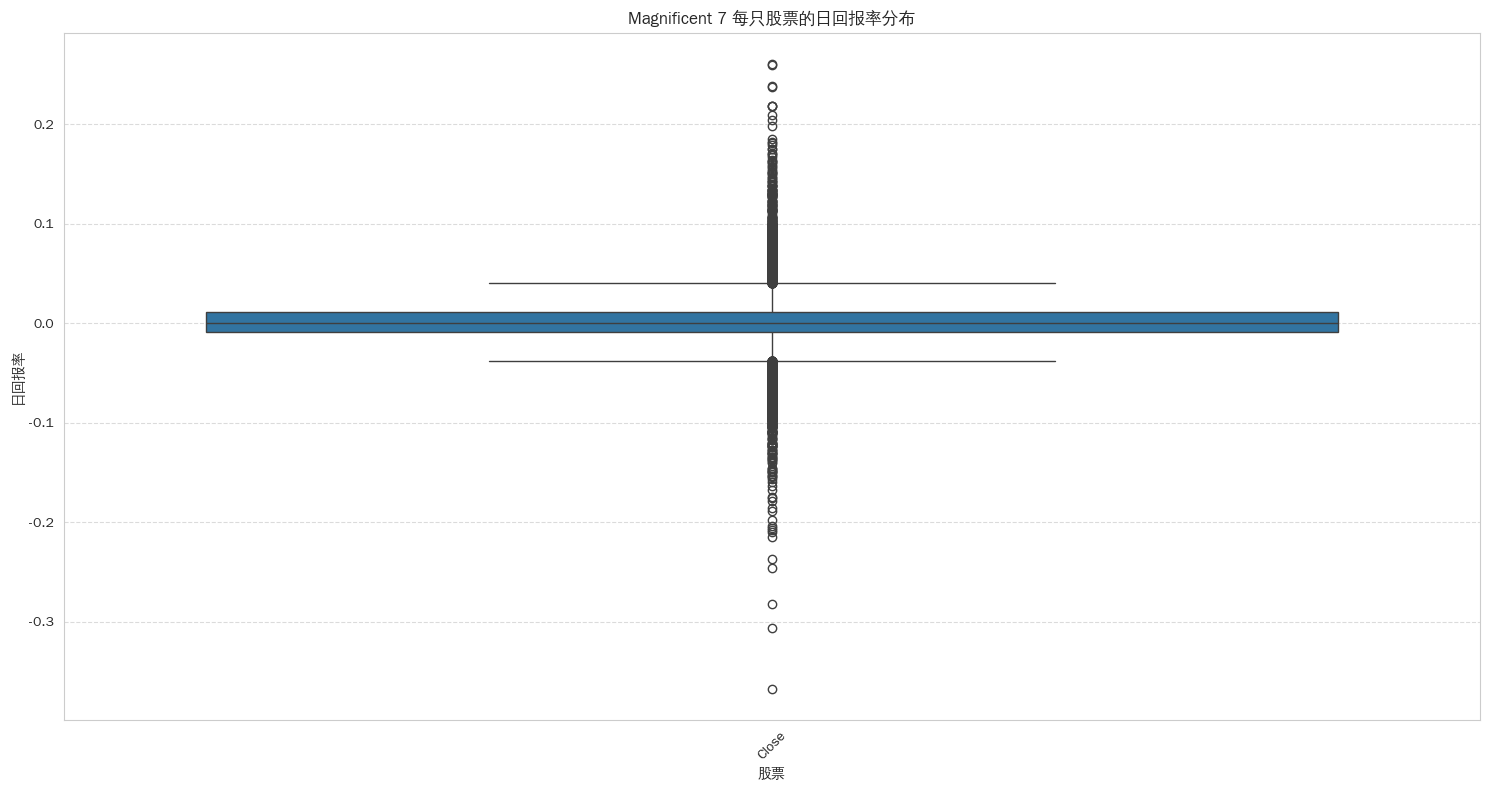


每只股票的回报率统计数据:


Price      Close                                                            
Ticker      AAPL      AMZN     GOOGL      META      MSFT      NVDA      TSLA
mean    0.001000  0.000900  0.000700  0.000600  0.000700  0.001300  0.001100
std     0.020200  0.023700  0.018900  0.020500  0.017300  0.031000  0.031700
min    -0.197500 -0.246200 -0.123700 -0.306400 -0.159500 -0.367100 -0.236500
max     0.142600  0.238600  0.182300  0.259400  0.170600  0.260900  0.218300
年化收益率   0.252000  0.226800  0.176400  0.151200  0.176400  0.327600  0.277200
年化波动率   0.320665  0.376226  0.300028  0.325427  0.274629  0.492110  0.503222
夏普比率    0.785867  0.602829  0.587945  0.464620  0.642321  0.665705  0.550850

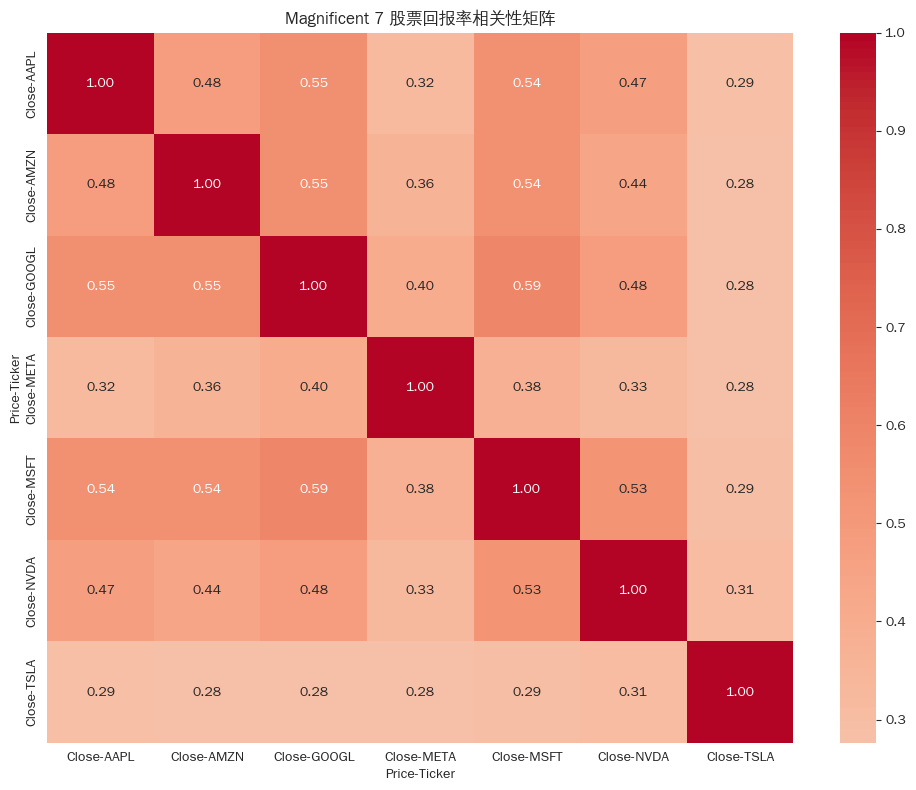

In [6]:
# 创建一个图形，设置适当的大小
plt.figure(figsize=(15, 8))

# 创建箱线图
sns.boxplot(data=returns)
plt.title('Magnificent 7 每只股票的日回报率分布')
plt.xticks(rotation=45)
plt.xlabel('股票')
plt.ylabel('日回报率')

# 添加网格线以便于查看
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# 调整布局以防止标签被切off
plt.tight_layout()
plt.show()

# 计算并显示每只股票的基本统计量
print("\n每只股票的回报率统计数据:")
stats = returns.agg(['mean', 'std', 'min', 'max']).round(4)
stats.loc['年化收益率'] = stats.loc['mean'] * 252
stats.loc['年化波动率'] = stats.loc['std'] * np.sqrt(252)
stats.loc['夏普比率'] = stats.loc['年化收益率'] / stats.loc['年化波动率']
display(stats)

# 计算相关性矩阵并可视化
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Magnificent 7 股票回报率相关性矩阵')

# 调整布局
plt.tight_layout()
plt.show()

In [7]:
# 检查数据结构和列名
print("回报率数据的列名:", returns.columns)
print("\n回报率数据的前几行:")
display(returns.head())

回报率数据的列名: MultiIndex([('Close',  'AAPL'),
            ('Close',  'AMZN'),
            ('Close', 'GOOGL'),
            ('Close',  'META'),
            ('Close',  'MSFT'),
            ('Close',  'NVDA'),
            ('Close',  'TSLA')],
           names=['Price', 'Ticker'])

回报率数据的前几行:


Price          Close                                                  
Ticker          AAPL      AMZN     GOOGL META      MSFT      NVDA TSLA
Date                                                                  
2005-09-26  0.000000  0.000000  0.000000  0.0  0.000000  0.000000  0.0
2005-09-27 -0.007457 -0.004162 -0.001083  0.0  0.002767  0.003331  0.0
2005-09-28 -0.045166  0.004854 -0.025617  0.0  0.012939  0.006027  0.0
2005-09-29  0.024368  0.032217  0.011761  0.0  0.010463  0.020515  0.0
2005-09-30  0.023975  0.011322  0.021851  0.0 -0.008128  0.008790  0.0

现在我们需要准备训练数据。我们将使用一个滑动窗口来创建输入序列和目标值。我们将使用过去20天的数据来预测下一天的最优权重分配。

In [8]:
def create_sequences(data, window_size=20):
    sequences = []
    targets = []
    
    for i in range(len(data) - window_size):
        sequence = data.iloc[i:i+window_size].values
        target = data.iloc[i+window_size].values
        sequences.append(sequence)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

# 创建训练数据
window_size = 20
X, y = create_sequences(returns, window_size)

print("输入数据形状:", X.shape)  # (样本数, 时间步长, 特征数)
print("目标数据形状:", y.shape)  # (样本数, 特征数)

输入数据形状: (5007, 20, 7)
目标数据形状: (5007, 7)


将数据分割为训练集和测试集：

In [9]:
# 将数据转换为PyTorch张量
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

# 首先分出测试集（20%）
train_val_size = int(0.8 * len(X))
X_test = X_tensor[train_val_size:]
y_test = y_tensor[train_val_size:]

# 然后将剩余数据分为训练集（80%）和验证集（20%）
train_size = int(0.8 * train_val_size)
X_train = X_tensor[:train_size]
y_train = y_tensor[:train_size]
X_val = X_tensor[train_size:train_val_size]
y_val = y_tensor[train_size:train_val_size]

print("数据集大小:")
print(f"训练集: {len(X_train)} 样本 ({len(X_train)/len(X_tensor):.1%})")
print(f"验证集: {len(X_val)} 样本 ({len(X_val)/len(X_tensor):.1%})")
print(f"测试集: {len(X_test)} 样本 ({len(X_test)/len(X_tensor):.1%})")

print("\n数据集形状:")
print(f"训练集: {X_train.shape}, {y_train.shape}")
print(f"验证集: {X_val.shape}, {y_val.shape}")
print(f"测试集: {X_test.shape}, {y_test.shape}")

数据集大小:
训练集: 3204 样本 (64.0%)
验证集: 801 样本 (16.0%)
测试集: 1002 样本 (20.0%)

数据集形状:
训练集: torch.Size([3204, 20, 7]), torch.Size([3204, 7])
验证集: torch.Size([801, 20, 7]), torch.Size([801, 7])
测试集: torch.Size([1002, 20, 7]), torch.Size([1002, 7])


创建PyTorch DataLoader以便批量训练：

In [10]:
from torch.utils.data import TensorDataset, DataLoader

# 创建数据集
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("数据加载器信息:")
print(f"训练批次数: {len(train_loader)}")
print(f"验证批次数: {len(val_loader)}")
print(f"测试批次数: {len(test_loader)}")

数据加载器信息:
训练批次数: 101
验证批次数: 26
测试批次数: 32


## 构建模型

我们将使用一个简单的LSTM网络来学习股票回报率序列的模式，并预测投资组合的最优权重分配。模型架构如下：

1. LSTM层：处理时序数据
2. 全连接层：将LSTM的输出转换为权重分配
3. Softmax层：确保权重和为1且非负

In [11]:
class PortfolioModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = torch.nn.Linear(hidden_size, input_size)
        self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        # LSTM层
        lstm_out, _ = self.lstm(x)
        # 我们只需要序列的最后一个时间步的输出
        last_output = lstm_out[:, -1, :]
        # 全连接层
        fc_out = self.fc(last_output)
        # Softmax确保输出是有效的权重分配
        weights = self.softmax(fc_out)
        return weights

# 实例化模型
input_size = X.shape[2]  # 特征数（股票数量）
hidden_size = 64
num_layers = 2

model = PortfolioModel(input_size, hidden_size, num_layers)
print(model)

PortfolioModel(
  (lstm): LSTM(7, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)


定义损失函数和优化器。我们的目标是最大化投资组合的预期收益，同时控制风险：

In [12]:
def portfolio_loss(weights, returns, risk_aversion=1.0):
    # 计算投资组合收益
    portfolio_return = torch.sum(weights * returns, dim=1)
    
    # 计算平均收益
    expected_return = torch.mean(portfolio_return)
    
    # 计算风险（使用样本标准差的平方而不是方差）
    # 添加小的常数以防止数值不稳定
    epsilon = 1e-8
    portfolio_risk = torch.mean((portfolio_return - expected_return) ** 2) + epsilon
    
    # 风险调整后的收益（负号是因为我们要最大化收益，而优化器是最小化损失）
    loss = -(expected_return - risk_aversion * portfolio_risk)
    
    # 添加正则化项以防止权重过于集中
    weight_regularization = torch.mean(torch.sum(weights ** 2, dim=1))
    regularization_factor = 0.01
    loss = loss + regularization_factor * weight_regularization
    
    return loss

# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 设置风险厌恶系数
risk_aversion = 5.0

## 训练模型

现在我们可以开始训练模型了。我们将跟踪每个epoch的训练损失和验证损失：

In [13]:
num_epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None
patience = 15
patience_counter = 0

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    epoch_train_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        weights = model(batch_X)
        loss = portfolio_loss(weights, batch_y, risk_aversion=risk_aversion)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # 验证阶段
    model.eval()
    epoch_val_loss = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            weights = model(batch_X)
            loss = portfolio_loss(weights, batch_y, risk_aversion=risk_aversion)
            epoch_val_loss += loss.item()
    
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)
    
    # 早停检查
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f'早停: 验证损失在 {patience} 个epoch内没有改善')
        break
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}')

# 加载最佳模型状态
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f'\n已恢复最佳模型（验证损失: {best_val_loss:.4f}）')

Epoch [5/50], Train Loss: 0.0015, Val Loss: 0.0018
Epoch [10/50], Train Loss: 0.0015, Val Loss: 0.0018
Epoch [10/50], Train Loss: 0.0015, Val Loss: 0.0018
Epoch [15/50], Train Loss: 0.0016, Val Loss: 0.0019
Epoch [15/50], Train Loss: 0.0016, Val Loss: 0.0019
Epoch [20/50], Train Loss: 0.0015, Val Loss: 0.0018
Epoch [20/50], Train Loss: 0.0015, Val Loss: 0.0018
Epoch [25/50], Train Loss: 0.0014, Val Loss: 0.0019
Epoch [25/50], Train Loss: 0.0014, Val Loss: 0.0019
Epoch [30/50], Train Loss: 0.0012, Val Loss: 0.0018
Epoch [30/50], Train Loss: 0.0012, Val Loss: 0.0018
Epoch [35/50], Train Loss: 0.0011, Val Loss: 0.0021
Epoch [35/50], Train Loss: 0.0011, Val Loss: 0.0021
Epoch [40/50], Train Loss: 0.0009, Val Loss: 0.0019
Epoch [40/50], Train Loss: 0.0009, Val Loss: 0.0019
早停: 验证损失在 15 个epoch内没有改善

已恢复最佳模型（验证损失: 0.0018）
早停: 验证损失在 15 个epoch内没有改善

已恢复最佳模型（验证损失: 0.0018）


可视化训练过程中的损失变化：

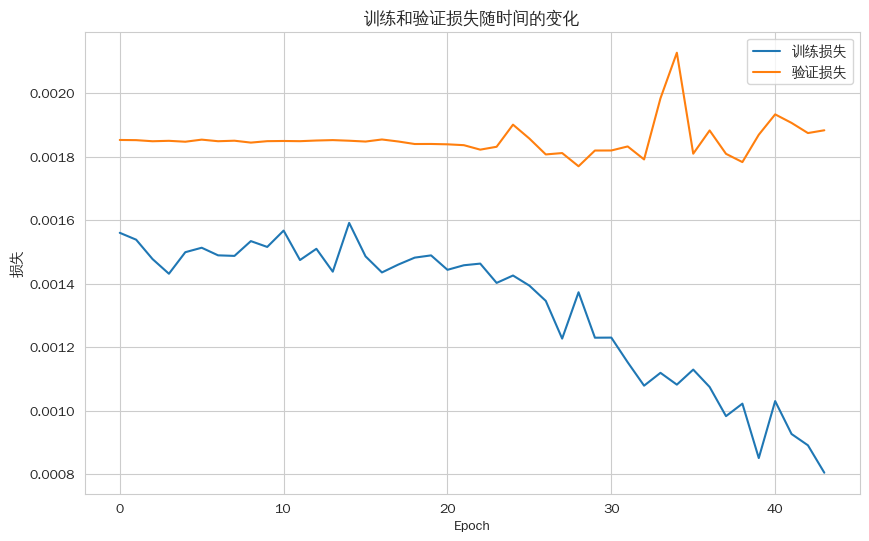

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.xlabel('Epoch')
plt.ylabel('损失')
plt.title('训练和验证损失随时间的变化')
plt.legend()
plt.grid(True)
plt.show()

## 评估模型

让我们使用训练好的模型在测试集上生成投资组合权重预测，并评估其表现：

投资组合表现指标:
年化收益率: 15.25%
年化波动率: 33.11%
夏普比率: 0.46


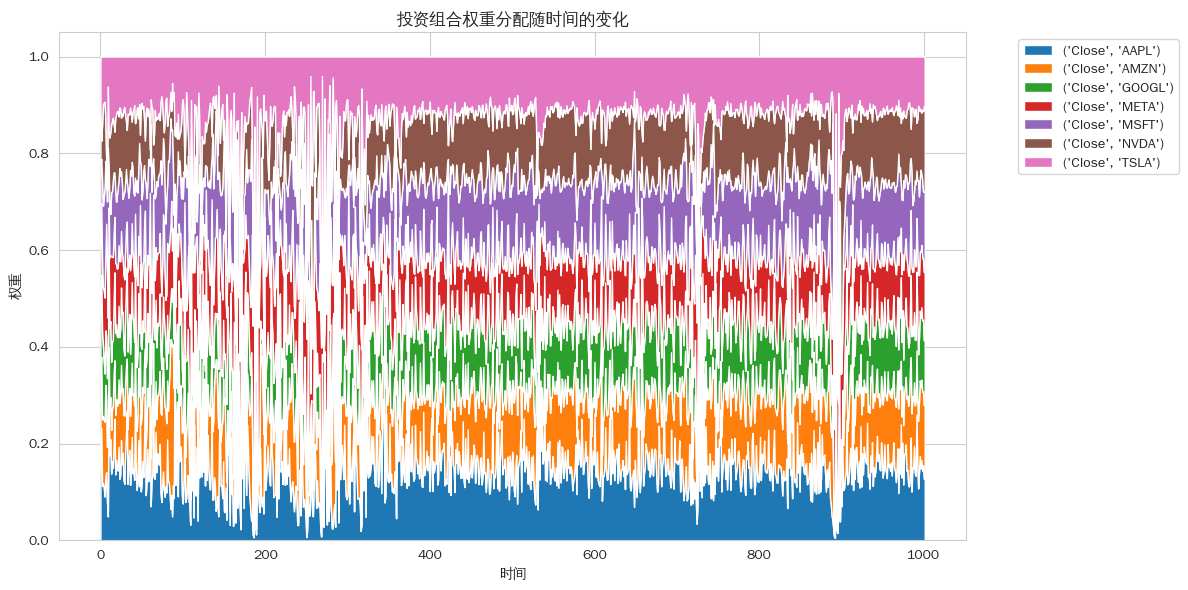

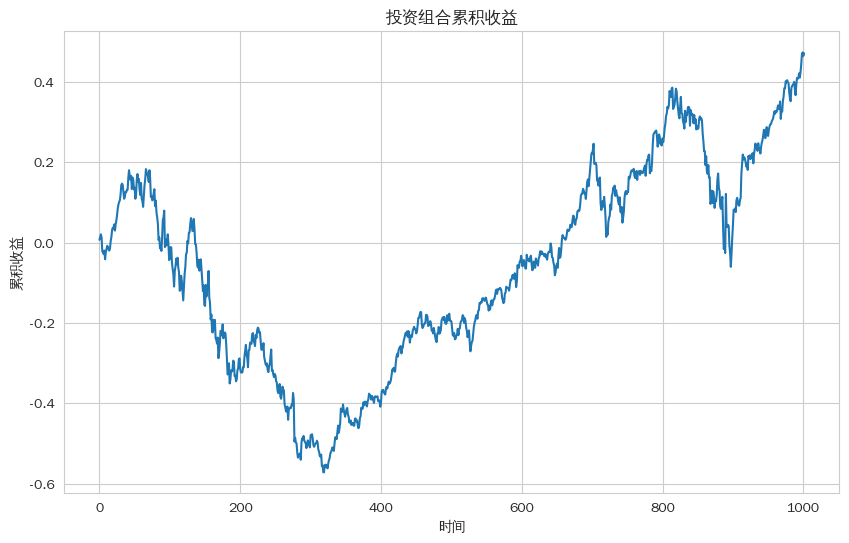

In [15]:
# 在测试集上生成预测
model.eval()
test_predictions = []
test_losses = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        weights = model(batch_X)
        loss = portfolio_loss(weights, batch_y, risk_aversion=risk_aversion)
        test_predictions.append(weights)
        test_losses.append(loss.item())

# 将预测结果转换为numpy数组
test_predictions = torch.cat(test_predictions, dim=0).numpy()

# 计算测试集上的投资组合表现
test_returns = y_test.numpy()
portfolio_returns = np.sum(test_predictions * test_returns, axis=1)

# 计算一些基本统计数据
mean_return = np.mean(portfolio_returns) * 252  # 年化收益率
std_return = np.std(portfolio_returns) * np.sqrt(252)  # 年化波动率
sharpe_ratio = mean_return / std_return  # 夏普比率

print(f"投资组合表现指标:")
print(f"年化收益率: {mean_return:.2%}")
print(f"年化波动率: {std_return:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")

# 可视化投资组合权重随时间的变化
plt.figure(figsize=(12, 6))
plt.stackplot(range(len(test_predictions)), 
             test_predictions.T,
             labels=returns.columns)
plt.xlabel('时间')
plt.ylabel('权重')
plt.title('投资组合权重分配随时间的变化')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 计算累积收益
cumulative_returns = np.cumprod(1 + portfolio_returns) - 1

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns)
plt.xlabel('时间')
plt.ylabel('累积收益')
plt.title('投资组合累积收益')
plt.grid(True)
plt.show()

## 使用TimesFM模型

我们将尝试使用Google Research的TimesFM预训练模型来优化投资组合。这个模型在大规模金融时间序列数据上进行了预训练，可能会带来更好的性能。

In [27]:
# 首先安装timesfm包
#!pip install timesfm

# 导入必要的库
import timesfm
import torch.nn as nn

# 创建TimesFM模型
timesfm_model = timesfm.TimesFM_2p5_200M_torch()

# 创建一个投资组合优化模型，使用TimesFM作为特征提取器
class TimesFMPortfolioModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.timesfm = timesfm_model
        
        # TimesFM的输出维度是512
        self.portfolio_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),  # 添加dropout以防止过拟合
            nn.Linear(256, output_size),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        # TimesFM期望的输入形状为 [batch_size, sequence_length, feature_dim]
        # 确保输入格式正确
        if x.dim() != 3:
            raise ValueError(f"Expected 3D input (batch, seq_len, features), got {x.dim()}D")
            
        # TimesFM处理并提取特征
        with torch.no_grad():  # 不需要计算TimesFM的梯度
            # 准备输入
            # 将batch_size个序列转换为list格式
            input_sequences = [x[i].cpu().numpy() for i in range(x.size(0))]
            
            # 使用forecast方法预测下一个时间步
            horizon = 1  # 我们只需要预测下一个时间步
            predictions, _ = self.timesfm.forecast(horizon, input_sequences)
            
            # 将预测结果转换回PyTorch张量并移到正确的设备上
            features = torch.from_numpy(predictions).to(x.device)
            
            # 确保特征形状正确
            # 如果是3D的[batch_size, horizon, features]，取最后一个时间步
            if features.dim() == 3:
                features = features[:, -1, :]  # 只使用最后一个时间步
                
            # 如果输出维度不是预期的512，打印警告
            if features.size(-1) != 512:
                print(f"Warning: Expected feature dim 512, got {features.size(-1)}")
            
        # 使用提取的特征生成投资组合权重
        weights = self.portfolio_head(features)
        return weights

# 实例化新模型
input_size = X.shape[2]  # 特征数（股票数量）
output_size = input_size  # 输出权重的维度与股票数量相同

# 将数据移至GPU（如果可用）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
timesfm_portfolio_model = TimesFMPortfolioModel(input_size, output_size).to(device)
print(f"使用设备: {device}")
print(timesfm_portfolio_model)

使用设备: cuda
TimesFMPortfolioModel(
  (portfolio_head): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=7, bias=True)
    (4): Softmax(dim=1)
  )
)


In [28]:
# 定义优化器和学习率
optimizer = torch.optim.Adam(timesfm_portfolio_model.parameters(), lr=0.0001)

# 训练TimesFM投资组合模型
num_epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None
patience = 15
patience_counter = 0

print(f"开始在 {device} 上训练模型...")

for epoch in range(num_epochs):
    # 训练阶段
    timesfm_portfolio_model.train()
    epoch_train_loss = 0
    
    for batch_X, batch_y in train_loader:
        # 确保数据在正确的设备上
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        weights = timesfm_portfolio_model(batch_X)
        loss = portfolio_loss(weights, batch_y, risk_aversion=risk_aversion)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # 验证阶段
    timesfm_portfolio_model.eval()
    epoch_val_loss = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            # 确保数据在正确的设备上
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            weights = timesfm_portfolio_model(batch_X)
            loss = portfolio_loss(weights, batch_y, risk_aversion=risk_aversion)
            epoch_val_loss += loss.item()
    
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)
    
    # 早停检查
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = timesfm_portfolio_model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f'早停: 验证损失在 {patience} 个epoch内没有改善')
        break
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}')

# 加载最佳模型状态
if best_model_state is not None:
    timesfm_portfolio_model.load_state_dict(best_model_state)
    print(f'\n已恢复最佳模型（验证损失: {best_val_loss:.4f}）')

开始在 cuda 上训练模型...


RuntimeError: Model is not compiled. Please call compile() first.

In [ ]:
# 在测试集上评估TimesFM模型
timesfm_portfolio_model.eval()
test_predictions = []
test_losses = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        weights = timesfm_portfolio_model(batch_X)
        loss = portfolio_loss(weights, batch_y, risk_aversion=risk_aversion)
        test_predictions.append(weights)
        test_losses.append(loss.item())

# 将预测结果转换为numpy数组
test_predictions = torch.cat(test_predictions, dim=0).numpy()

# 计算测试集上的投资组合表现
test_returns = y_test.numpy()
portfolio_returns = np.sum(test_predictions * test_returns, axis=1)

# 计算一些基本统计数据
mean_return = np.mean(portfolio_returns) * 252  # 年化收益率
std_return = np.std(portfolio_returns) * np.sqrt(252)  # 年化波动率
sharpe_ratio = mean_return / std_return  # 夏普比率

print(f"TimesFM投资组合表现指标:")
print(f"年化收益率: {mean_return:.2%}")
print(f"年化波动率: {std_return:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")

# 可视化TimesFM模型的投资组合权重分配
plt.figure(figsize=(12, 6))
plt.stackplot(range(len(test_predictions)), 
             test_predictions.T,
             labels=returns.columns)
plt.xlabel('时间')
plt.ylabel('权重')
plt.title('TimesFM模型 - 投资组合权重分配随时间的变化')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 计算并绘制累积收益
cumulative_returns = np.cumprod(1 + portfolio_returns) - 1

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns)
plt.xlabel('时间')
plt.ylabel('累积收益')
plt.title('TimesFM模型 - 投资组合累积收益')
plt.grid(True)
plt.show()

In [ ]:
# 将数据移至GPU
if torch.cuda.is_available():
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_val = X_val.cuda()
    y_val = y_val.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()

# 重新创建DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("数据已移至:", device)

In [ ]:
# 检查TimesFM模型的可用方法
print("TimesFM模型可用方法:")
print([method for method in dir(timesfm_model) if not method.startswith('_')])

# 检查输入数据的形状和类型
print("\n输入数据信息:")
print(f"输入形状: {X_train.shape}")
print(f"输入类型: {X_train.dtype}")
print(f"数值范围: [{X_train.min().item():.4f}, {X_train.max().item():.4f}]")